# Correlation Analysis for Vulnerability Score Variables

This notebook identifies the most relevant weather variables for computing **heatwave** and **rainfall vulnerability scores** per census section per day.

**Objective:** Analyze correlations between weather variables (especially heatwave and intense rainfall indicators) and consumption/leaks to determine:
1. Which weather variables to include in vulnerability scores
2. Appropriate weights for each variable based on correlation strength

**Output:** Recommendations stored in `vulnerability_score_config` dictionary for use in `vulnerabilityScore.ipynb`

In [27]:
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Data Loading

Load cleaned datasets from `cleaningEDA.ipynb`:
- **Consumption data**: Split parquet files in `clean/split_consum_bcn/`
- **Leak incidents data**: Single parquet file `clean/fuites_clean_bcn.parquet`
- **Weather data**: `clean/weather_clean.parquet`

In [28]:
# Load cleaned datasets
df_weather = pd.read_parquet("clean/weather_clean.parquet")
df_fuites = pd.read_parquet("clean/fuites_clean_bcn.parquet")
consum_files = sorted(glob.glob("clean/split_consum_bcn/consum_clean_bcn_part_*.parquet"))
df_consum_list = [pd.read_parquet(fp) for fp in consum_files]
df_consum = pd.concat(df_consum_list, ignore_index=True)

print("Loaded datasets:")
print(f"  Weather: {df_weather.shape[0]:,} rows")
print(f"  Leaks: {df_fuites.shape[0]:,} rows")
print(f"  Consumption: {df_consum.shape[0]:,} rows from {len(consum_files)} split files")

Loaded datasets:
  Weather: 129,086 rows
  Leaks: 1,359 rows
  Consumption: 10,068,280 rows from 18 split files


## 1. Advanced Data Validation

Comprehensive validation to ensure data quality before correlation analysis. This includes checks for data types, missing values, temporal/spatial coverage, duplicates, outliers, and value ranges.

### 1.1 Column Types, Missing Values, and Duplicates

In [29]:
print("="*120)
print("ADVANCED DATA VALIDATION REPORT")
print("="*120)

# Validation helper function
def validate_dataset(df, name):
    """Validate dataset: column types, missing values, and duplicates."""
    print("\n" + "-"*80)
    print(f"VALIDATION: {name}")
    print("-"*80)
    
    # Check column types
    print("\nColumn types:")
    print(df.dtypes)
    
    # Missing values
    print("\nMissing values (top 10):")
    missing = df.isna().sum().sort_values(ascending=False)
    missing_nonzero = missing[missing > 0]
    if len(missing_nonzero) > 0:
        print(missing_nonzero.head(10))
    else:
        print("  ✓ No missing values")
    
    # Duplicate rows
    dup_count = df.duplicated().sum()
    print(f"\nDuplicate rows: {dup_count:,}")
    if dup_count == 0:
        print("  ✓ No duplicate rows")

# Validate all datasets
validate_dataset(df_consum, "Consumption")
validate_dataset(df_fuites, "Leaks")
validate_dataset(df_weather, "Weather")


ADVANCED DATA VALIDATION REPORT

--------------------------------------------------------------------------------
VALIDATION: Consumption
--------------------------------------------------------------------------------

Column types:
POLIZA_SUMINISTRO            object
FECHA                datetime64[ns]
CONSUMO_REAL                  int64
SECCIO_CENSAL                object
US_AIGUA_GEST                object
DATA_INST_COMP       datetime64[ns]
dtype: object

Missing values (top 10):
  ✓ No missing values

Duplicate rows: 0
  ✓ No duplicate rows

--------------------------------------------------------------------------------
VALIDATION: Leaks
--------------------------------------------------------------------------------

Column types:
POLISSA_SUBM       object
CREATED_MENSAJE    object
CODIGO_MENSAJE     object
US_AIGUA_SUBM      object
SECCIO_CENSAL      object
dtype: object

Missing values (top 10):
  ✓ No missing values

Duplicate rows: 0
  ✓ No duplicate rows

-----------------

### 1.2 Temporal Coverage and Missing Days

Check date ranges, null dates, and identify missing days in the time series.


In [30]:
# Convert date columns to datetime
df_consum['FECHA'] = pd.to_datetime(df_consum['FECHA'], errors='coerce')
df_fuites['CREATED_MENSAJE'] = pd.to_datetime(df_fuites['CREATED_MENSAJE'], errors='coerce')
df_weather['DATA_LECTURA'] = pd.to_datetime(df_weather['DATA_LECTURA'], errors='coerce')

def validate_dates(df, date_col, name):
    """Validate temporal coverage: date ranges, nulls, and missing days."""
    print("\n" + "-"*80)
    print(f"TEMPORAL VALIDATION: {name}")
    print("-"*80)

    if date_col not in df.columns:
        print(f"⚠ Date column '{date_col}' missing!")
        return
    
    n_null = df[date_col].isna().sum()
    print(f"Null dates: {n_null:,}")
    print(f"Earliest date: {df[date_col].min()}")
    print(f"Latest date: {df[date_col].max()}")
    print(f"Unique dates: {df[date_col].nunique():,}")
    
    # Check for missing days in the date range
    dates = df[date_col].dropna().sort_values()
    if len(dates) > 0:
        full_range = pd.date_range(start=dates.min(), end=dates.max(), freq="D")
        missing_days = full_range.difference(dates.unique())
        print(f"Missing days in range: {len(missing_days):,}")
        if len(missing_days) > 0 and len(missing_days) <= 20:
            print("Missing days:", missing_days.tolist())
        elif len(missing_days) > 20:
            print(f"First 20 missing days: {missing_days[:20].tolist()}")

validate_dates(df_consum, "FECHA", "Consumption")
validate_dates(df_fuites, "CREATED_MENSAJE", "Leaks")
validate_dates(df_weather, "DATA_LECTURA", "Weather")



--------------------------------------------------------------------------------
TEMPORAL VALIDATION: Consumption
--------------------------------------------------------------------------------
Null dates: 0
Earliest date: 2021-01-01 00:00:00
Latest date: 2024-12-31 00:00:00
Unique dates: 1,458
Missing days in range: 3
Missing days: [Timestamp('2022-07-08 00:00:00'), Timestamp('2022-07-09 00:00:00'), Timestamp('2022-07-10 00:00:00')]

--------------------------------------------------------------------------------
TEMPORAL VALIDATION: Leaks
--------------------------------------------------------------------------------
Null dates: 0
Earliest date: 2023-01-04 00:00:00
Latest date: 2025-05-27 00:00:00
Unique dates: 505
Missing days in range: 370
First 20 missing days: [Timestamp('2023-01-05 00:00:00'), Timestamp('2023-01-06 00:00:00'), Timestamp('2023-01-07 00:00:00'), Timestamp('2023-01-10 00:00:00'), Timestamp('2023-01-13 00:00:00'), Timestamp('2023-01-14 00:00:00'), Timestamp('2023

### 1.3 Spatial Coverage (Census Sections)

Validate census section codes format and coverage.


In [31]:
def validate_spatial(df, name):
    """Validate spatial coverage: census section codes format and count."""
    print("\n" + "-"*80)
    print(f"SPATIAL VALIDATION: {name}")
    print("-"*80)

    if "SECCIO_CENSAL" not in df.columns:
        print("⚠ Missing SECCIO_CENSAL column")
        return

    unique_sections = df["SECCIO_CENSAL"].nunique()
    print(f"Unique SECCIO_CENSAL count: {unique_sections:,}")

    # Check formatting: all codes should be 11 digits starting with 080193
    mask_valid = df["SECCIO_CENSAL"].astype(str).str.match(r"^080193\d{5}$")
    invalid = df.loc[~mask_valid, "SECCIO_CENSAL"]

    print(f"Invalid census codes: {len(invalid)}")
    if len(invalid) > 0:
        print("Sample invalid codes:")
        print(invalid.head(10))
    else:
        print("  ✓ All census codes valid")

validate_spatial(df_consum, "Consumption")
validate_spatial(df_fuites, "Leaks")



--------------------------------------------------------------------------------
SPATIAL VALIDATION: Consumption
--------------------------------------------------------------------------------
Unique SECCIO_CENSAL count: 621
Invalid census codes: 0
  ✓ All census codes valid

--------------------------------------------------------------------------------
SPATIAL VALIDATION: Leaks
--------------------------------------------------------------------------------
Unique SECCIO_CENSAL count: 436
Invalid census codes: 0
  ✓ All census codes valid


### 1.4 Duplicate Meter-Date Combinations

Check for duplicate consumption records (same meter, same date).


In [32]:
# Check for duplicate meter-date combinations
dup_meter_date = df_consum.duplicated(subset=["POLIZA_SUMINISTRO", "FECHA"]).sum()
print(f"Duplicate (POLIZA_SUMINISTRO + FECHA) rows: {dup_meter_date:,}")
if dup_meter_date == 0:
    print("  ✓ No duplicate meter-date combinations")
else:
    print("  ⚠ Duplicates found - may need deduplication")


Duplicate (POLIZA_SUMINISTRO + FECHA) rows: 0
  ✓ No duplicate meter-date combinations


### 1.5 Weather Value Validation (Unit-aware)

Validate weather values are within expected ranges for each unit type.


In [33]:
# Weather value validation rules by unit
weather_validation_rules = {
    "°C": (-40, 50),        # realistic temperature range for Barcelona
    "%": (0, 100),          # valid humidity range
    "hPa": (900, 1100),     # typical pressure range
    "mm": (0, 500),         # rainfall per day upper cap (rare but possible)
    "MJ/m2": (0, 40),       # solar radiation
    "m/s": (0, 40),         # wind speed
    "°": (0, 360)           # direction angles
}

print("Unique UNITAT values in df_weather:")
print(df_weather["UNITAT"].unique())

invalid_summary = []

for unit, (lo, hi) in weather_validation_rules.items():
    mask = df_weather["UNITAT"] == unit
    subset = df_weather[mask]
    
    if len(subset) == 0:
        continue

    invalid = subset[(subset["VALOR_NUM"] < lo) | (subset["VALOR_NUM"] > hi)]
    invalid_summary.append((unit, len(invalid)))

    print(f"\nUNIT: {unit}")
    print(f"  Allowed range: {lo} to {hi}")
    print(f"  Rows checked: {len(subset):,}")
    print(f"  Invalid values: {len(invalid):,}")
    if len(invalid) == 0:
        print("  ✓ All values within valid range")

print("\nSummary of invalid per unit:")
for u, cnt in invalid_summary:
    status = "✓" if cnt == 0 else "⚠"
    print(f"  {status} {u}: {cnt} invalid values")


Unique UNITAT values in df_weather:
['°C' '%' 'hPa' 'mm' 'MJ/m2' 'm/s' '°']

UNIT: °C
  Allowed range: -40 to 50
  Rows checked: 33,525
  Invalid values: 0
  ✓ All values within valid range

UNIT: %
  Allowed range: 0 to 100
  Rows checked: 20,115
  Invalid values: 0
  ✓ All values within valid range

UNIT: hPa
  Allowed range: 900 to 1100
  Rows checked: 16,002
  Invalid values: 0
  ✓ All values within valid range

UNIT: mm
  Allowed range: 0 to 500
  Rows checked: 31,960
  Invalid values: 0
  ✓ All values within valid range

UNIT: MJ/m2
  Allowed range: 0 to 40
  Rows checked: 5,333
  Invalid values: 0
  ✓ All values within valid range

UNIT: m/s
  Allowed range: 0 to 40
  Rows checked: 11,080
  Invalid values: 0
  ✓ All values within valid range

UNIT: °
  Allowed range: 0 to 360
  Rows checked: 11,071
  Invalid values: 0
  ✓ All values within valid range

Summary of invalid per unit:
  ✓ °C: 0 invalid values
  ✓ %: 0 invalid values
  ✓ hPa: 0 invalid values
  ✓ mm: 0 invalid values

### 1.6 Outlier Detection

Identify statistical outliers in consumption and leak frequency data.


In [34]:
# Consumption outliers (IQR method)
q1 = df_consum["CONSUMO_REAL"].quantile(0.25)
q3 = df_consum["CONSUMO_REAL"].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 3 * iqr   # conservative threshold
lower_bound = q1 - 1.5 * iqr

outliers_high = df_consum[df_consum["CONSUMO_REAL"] > upper_bound]
outliers_low = df_consum[df_consum["CONSUMO_REAL"] < lower_bound]

print("Consumption outlier analysis:")
print(f"  Total consumption rows: {len(df_consum):,}")
print(f"  High outliers (> {upper_bound:.1f}): {len(outliers_high):,} ({len(outliers_high)/len(df_consum)*100:.2f}%)")
print(f"  Low outliers (< {lower_bound:.1f}): {len(outliers_low):,} ({len(outliers_low)/len(df_consum)*100:.2f}%)")

# Leak frequency outliers (days with unusually high leak counts)
daily_leak_counts = df_fuites.groupby("CREATED_MENSAJE").size()
mean_leaks = daily_leak_counts.mean()
std_leaks = daily_leak_counts.std()

high_leak_days = daily_leak_counts[daily_leak_counts > mean_leaks + 3*std_leaks]

print("\nLeak frequency outlier analysis:")
print(f"  Mean leaks/day: {mean_leaks:.2f}")
print(f"  Std leaks/day: {std_leaks:.2f}")
print(f"  High leak anomaly days (> mean + 3σ): {len(high_leak_days)}")
if len(high_leak_days) > 0:
    print("  Sample high leak days:")
    print(high_leak_days.head())


Consumption outlier analysis:
  Total consumption rows: 10,068,280
  High outliers (> 1080.0): 259,914 (2.58%)
  Low outliers (< -295.0): 0 (0.00%)

Leak frequency outlier analysis:
  Mean leaks/day: 2.69
  Std leaks/day: 2.23
  High leak anomaly days (> mean + 3σ): 12
  Sample high leak days:
CREATED_MENSAJE
2023-11-12    10
2023-11-22    10
2023-12-08    11
2023-12-27    12
2024-02-06    13
dtype: int64


### 1.7 Meter Stability Check

Analyze meter reading frequency and gaps to identify meters with irregular data collection.


In [35]:
# Count readings per meter
counts_per_meter = df_consum.groupby("POLIZA_SUMINISTRO")["FECHA"].nunique()

print("Meter reading frequency:")
print(f"  Total meters: {len(counts_per_meter):,}")
print(f"  Meters with < 30 days: {(counts_per_meter < 30).sum():,} ({(counts_per_meter < 30).sum()/len(counts_per_meter)*100:.2f}%)")
print(f"  Meters with < 7 days:  {(counts_per_meter < 7).sum():,} ({(counts_per_meter < 7).sum()/len(counts_per_meter)*100:.2f}%)")

if (counts_per_meter < 7).sum() > 0:
    print("\n  Sample meters with extremely few readings:")
    print(counts_per_meter[counts_per_meter < 7].head(10))

# Analyze gaps between meter readings
def meter_gap_analysis(df):
    """Calculate maximum gap between readings for each meter."""
    gaps = []
    for meter, group in df.groupby("POLIZA_SUMINISTRO"):
        dates = group["FECHA"].dropna().sort_values()
        if len(dates) < 2:
            continue
        diffs = dates.diff().dt.days
        max_gap = diffs.max()
        gaps.append(max_gap)
    return gaps

meter_gaps = meter_gap_analysis(df_consum)

print("\nMeter gap analysis:")
print(f"  Meters analyzed: {len(meter_gaps):,}")
print(f"  Average max gap: {np.mean(meter_gaps):.2f} days")
print(f"  Meters with gaps > 60 days: {(np.array(meter_gaps) > 60).sum():,} ({(np.array(meter_gaps) > 60).sum()/len(meter_gaps)*100:.2f}%)")
print(f"  Meters with gaps > 90 days: {(np.array(meter_gaps) > 90).sum():,} ({(np.array(meter_gaps) > 90).sum()/len(meter_gaps)*100:.2f}%)")

print("\n" + "="*120)
print("✓ ADVANCED DATA VALIDATION COMPLETED")
print("="*120)


Meter reading frequency:
  Total meters: 6,930
  Meters with < 30 days: 0 (0.00%)
  Meters with < 7 days:  0 (0.00%)

Meter gap analysis:
  Meters analyzed: 6,930
  Average max gap: 4.63 days
  Meters with gaps > 60 days: 0 (0.00%)
  Meters with gaps > 90 days: 0 (0.00%)

✓ ADVANCED DATA VALIDATION COMPLETED


## 2. Data Preparation

Prepare daily aggregates and pivot weather variables for correlation analysis.

### 2.1 Daily Aggregates

In [36]:
# Daily total consumption (sum over all census sections)
daily_consum = (
    df_consum
    .groupby('FECHA')['CONSUMO_REAL']
    .sum()
    .reset_index()
    .rename(columns={'FECHA': 'date', 'CONSUMO_REAL': 'total_consumption'})
)

# Daily number of leaks (count of leak events)
daily_leaks = (
    df_fuites
    .groupby('CREATED_MENSAJE')['POLISSA_SUBM']
    .count()
    .reset_index()
    .rename(columns={'CREATED_MENSAJE': 'date', 'POLISSA_SUBM': 'num_leaks'})
)

print(f"Daily consumption: {len(daily_consum):,} days")
print(f"Daily leaks: {len(daily_leaks):,} days")


Daily consumption: 1,458 days
Daily leaks: 505 days


### 2.2 Weather Variables Pivot

Pivot all weather variables to columns for correlation analysis. All 24 weather variables are included to enable comprehensive extreme weather event characterization.

In [37]:
# Pivot weather variables: NOM_VARIABLE → columns
# Include ALL weather variables for comprehensive extreme weather event characterization
weather_vars = {
    # Temperature variables
    "Temperatura mitjana diària": "temp_avg",
    "Temperatura màxima diària + hora": "temp_max",
    "Temperatura mínima diària + hora": "temp_min",
    "Temperatura mitjana diària clàssica": "temp_avg_classic",
    "Amplitud tèrmica diària": "temp_amplitude",
    
    # Humidity variables
    "Humitat relativa mitjana diària": "humidity_avg",
    "Humitat relativa màxima diària + data": "humidity_max",
    "Humitat relativa mínima diària + data": "humidity_min",
    
    # Pressure variables
    "Pressió atmosfèrica mitjana diària": "pressure_avg",
    "Pressió atmosfèrica màxima diària + hora": "pressure_max",
    "Pressió atmosfèrica mínima diària + hora": "pressure_min",
    
    # Precipitation variables (important for intense rainfall events)
    "Precipitació acumulada diària": "rain_daily",
    "Precipitació acumulada diària (8-8 h)": "rain_8h",
    "Precipitació màxima en 1 min (diària) + hora": "rain_max_1min",
    "Precipitació màxima en 1 h (diària) + hora": "rain_max_1h",
    "Precipitació màxima en 30 min (diària)+ hora": "rain_max_30min",
    
    # Solar radiation (important for heatwaves)
    "Irradiació solar global diària": "solar_global",
    
    # Wind variables
    "Velocitat mitjana diària del vent 10 m (esc.)": "wind_speed_avg_esc",
    "Velocitat mitjana diària del vent 10 m (vec.)": "wind_speed_avg_vec",
    "Direcció mitjana diària del vent 10 m (m. 1)": "wind_dir_avg_m1",
    "Direcció mitjana diària del vent 10 m (m. u)": "wind_dir_avg_mu",
    "Ratxa màxima diària del vent 10 m + hora": "wind_gust_max",
    "Direcció de la ratxa màx. diària de vent 10 m": "wind_gust_dir",
    
    # Evapotranspiration (important for heat stress)
    "Evapotranspiració de referència": "evapotranspiration",
}

weather_sub = df_weather[df_weather["NOM_VARIABLE"].isin(weather_vars.keys())].copy()
weather_sub["variable"] = weather_sub["NOM_VARIABLE"].map(weather_vars)

weather_pivot = (
    weather_sub
    .pivot_table(
        index='DATA_LECTURA',
        columns='variable',
        values='VALOR_NUM',
        aggfunc='mean'
    )
    .reset_index()
    .rename(columns={'DATA_LECTURA': 'date'})
)

### 2.3 Build Correlation Dataset

In [38]:
# Merge daily aggregates with weather data
df_corr = (
    daily_consum
    .merge(daily_leaks, on='date', how='left')
    .merge(weather_pivot, on='date', how='left')
)

# Missing leaks = 0 leaks that day
df_corr['num_leaks'] = df_corr['num_leaks'].fillna(0)

print(f"Correlation dataset shape: {df_corr.shape}")
print(f"Date range: {df_corr['date'].min()} to {df_corr['date'].max()}")
print(f"\nAvailable weather variables: {len([c for c in df_corr.columns if c not in ['date', 'total_consumption', 'num_leaks']])}")
print("✓ Correlation dataset ready for analysis")


Correlation dataset shape: (1458, 27)
Date range: 2021-01-01 00:00:00 to 2024-12-31 00:00:00

Available weather variables: 24
✓ Correlation dataset ready for analysis


## 3. Heatwave Variables Analysis

Analyze correlations between heatwave-related weather variables and consumption/leaks to identify the most important variables for the heatwave vulnerability score.

### 3.1 Heatwave Variables

**Heatwave-related variables:**
- Temperature: temp_max, temp_avg, temp_min, temp_amplitude, temp_avg_classic
- Solar radiation: solar_global
- Evapotranspiration: evapotranspiration (indicator of heat stress)
- Humidity: humidity_avg, humidity_max, humidity_min (high humidity + high temp = heat index)


### 3.2 Heatwave Correlation Analysis

Calculate correlations between heatwave-related weather variables and consumption/leaks.

- **Leak density adds new information**
  - `leaks_per_1000_meters` is only moderately correlated with total leaks (r ≈ 0.45–0.48).
  - This metric captures how *leaky* a section is **relative to the size of its network**, so it contributes a distinct dimension of vulnerability.

- **Consumption strongly reflects network size**
  - `mean_daily_consumption` and `num_meters` are strongly correlated (r ≈ 0.79).
  - High total consumption is mostly driven by having many meters (larger or denser network areas).

- **Intensity vs. size**
  - `consumption_per_meter` has only a moderate correlation with `mean_daily_consumption` (r ≈ 0.40).
  - Some sections are “big” (many meters), others are “intense” (high use per meter) – both aspects are relevant for hydraulic stress.

- **Leaks vs. consumption**
  - Sections with higher `mean_daily_consumption` tend to have more leaks (r ≈ 0.23–0.30), but the relationship is not very strong.
  - When normalized (`leaks_per_1000_meters`), the correlation with consumption becomes slightly negative (r ≈ –0.15), suggesting that **high use does not always mean proportionally leakier networks**.

- **Socioeconomic index is weakly linked to technical behaviour**
  - `socio_index` shows only very small correlations (|r| ≤ ~0.15) with leaks, consumption and number of meters.
  - Socioeconomic status should therefore be treated as a **separate social vulnerability layer**, not as a proxy for technical risk.


In [39]:
# Define heatwave-related variables
heatwave_vars = [
    'temp_max', 'temp_avg', 'temp_min', 'temp_amplitude', 'temp_avg_classic',
    'solar_global',
    'evapotranspiration',
    'humidity_avg', 'humidity_max', 'humidity_min'
]

# Get available heatwave variables
heatwave_vars_available = [v for v in heatwave_vars if v in df_corr.columns]
print(f"Available heatwave variables: {len(heatwave_vars_available)}/{len(heatwave_vars)}")
print(f"Variables: {heatwave_vars_available}")

# Create subset with heatwave variables + consumption & leaks
heatwave_df = df_corr[['total_consumption', 'num_leaks'] + heatwave_vars_available].copy()
heatwave_df = heatwave_df.dropna()

print(f"Data points available: {len(heatwave_df):,}")

# Calculate correlation matrix
heatwave_corr = heatwave_df.corr()


Available heatwave variables: 10/10
Variables: ['temp_max', 'temp_avg', 'temp_min', 'temp_amplitude', 'temp_avg_classic', 'solar_global', 'evapotranspiration', 'humidity_avg', 'humidity_max', 'humidity_min']
Data points available: 1,458


#### 3.2.1 Correlation Results

Extract and display correlations between heatwave variables and consumption/leaks.


In [40]:
# Extract and display correlations with consumption and leaks
consum_heatwave = heatwave_corr['total_consumption'][heatwave_vars_available].abs().sort_values(ascending=False)
leaks_heatwave = heatwave_corr['num_leaks'][heatwave_vars_available].abs().sort_values(ascending=False)

print("CORRELATIONS WITH TOTAL_CONSUMPTION")
print("="*80)
print("Absolute correlations (sorted by strength):")
for var, corr_val in consum_heatwave.items():
    actual_corr = heatwave_corr.loc['total_consumption', var]
    print(f"  {var:25s}: {actual_corr:7.3f} (abs: {corr_val:.3f})")

print("\nCORRELATIONS WITH NUM_LEAKS")
print("="*80)
print("Absolute correlations (sorted by strength):")
for var, corr_val in leaks_heatwave.items():
    actual_corr = heatwave_corr.loc['num_leaks', var]
    print(f"  {var:25s}: {actual_corr:7.3f} (abs: {corr_val:.3f})")


CORRELATIONS WITH TOTAL_CONSUMPTION
Absolute correlations (sorted by strength):
  evapotranspiration       :   0.119 (abs: 0.119)
  temp_min                 :   0.118 (abs: 0.118)
  temp_avg                 :   0.118 (abs: 0.118)
  temp_avg_classic         :   0.116 (abs: 0.116)
  solar_global             :   0.115 (abs: 0.115)
  temp_max                 :   0.111 (abs: 0.111)
  humidity_min             :  -0.020 (abs: 0.020)
  humidity_avg             :  -0.019 (abs: 0.019)
  humidity_max             :   0.017 (abs: 0.017)
  temp_amplitude           :  -0.001 (abs: 0.001)

CORRELATIONS WITH NUM_LEAKS
Absolute correlations (sorted by strength):
  temp_avg_classic         :   0.069 (abs: 0.069)
  temp_avg                 :   0.069 (abs: 0.069)
  temp_max                 :   0.069 (abs: 0.069)
  temp_min                 :   0.068 (abs: 0.068)
  evapotranspiration       :   0.040 (abs: 0.040)
  solar_global             :   0.037 (abs: 0.037)
  humidity_max             :   0.020 (abs: 0.02

#### 3.2.2 Correlation Visualization

Visualize the correlation matrix between heatwave variables and consumption/leaks.


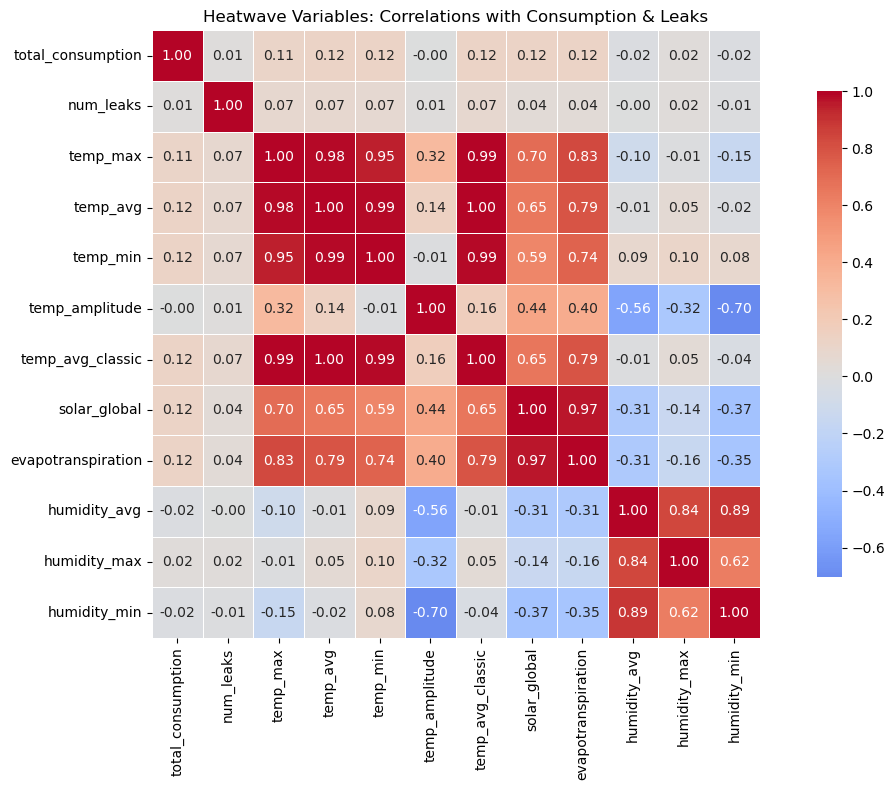

In [41]:
# Visualize heatwave correlation matrix
plt.figure(figsize=(12, 8))
heatwave_corr_viz = heatwave_corr.loc[['total_consumption', 'num_leaks'] + heatwave_vars_available,
                                       ['total_consumption', 'num_leaks'] + heatwave_vars_available]
sns.heatmap(
    heatwave_corr_viz,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Heatwave Variables: Correlations with Consumption & Leaks")
plt.tight_layout()
plt.show()


#### 3.2.3 Extreme Heat Days Analysis


In [42]:
# Analyze extreme heat days (top 10% and 5% of temp_max)
if 'temp_max' in heatwave_df.columns:
    heat_threshold_90 = heatwave_df['temp_max'].quantile(0.90)
    heat_threshold_95 = heatwave_df['temp_max'].quantile(0.95)
    
    print("Temperature thresholds:")
    print(f"  90th percentile (top 10%): {heat_threshold_90:.2f} °C")
    print(f"  95th percentile (top 5%):   {heat_threshold_95:.2f} °C")
    
    # Compare consumption and leaks on extreme heat days vs normal days
    extreme_heat_90 = heatwave_df['temp_max'] >= heat_threshold_90
    extreme_heat_95 = heatwave_df['temp_max'] >= heat_threshold_95
    
    print(f"\nDays with extreme heat (≥90th percentile): {extreme_heat_90.sum():,}")
    print(f"Days with extreme heat (≥95th percentile): {extreme_heat_95.sum():,}")
    
    print("\nConsumption comparison:")
    print(f"  Normal days:        {heatwave_df[~extreme_heat_90]['total_consumption'].mean():,.0f} L/day")
    print(f"  Extreme heat (90): {heatwave_df[extreme_heat_90]['total_consumption'].mean():,.0f} L/day")
    diff_consum = heatwave_df[extreme_heat_90]['total_consumption'].mean() - heatwave_df[~extreme_heat_90]['total_consumption'].mean()
    pct_increase = (heatwave_df[extreme_heat_90]['total_consumption'].mean() / heatwave_df[~extreme_heat_90]['total_consumption'].mean() - 1) * 100
    print(f"  Difference:        {diff_consum:,.0f} L/day ({pct_increase:.1f}% increase)")
    
    print("\nLeaks comparison:")
    print(f"  Normal days:        {heatwave_df[~extreme_heat_90]['num_leaks'].mean():.2f} leaks/day")
    print(f"  Extreme heat (90): {heatwave_df[extreme_heat_90]['num_leaks'].mean():.2f} leaks/day")
    diff_leaks = heatwave_df[extreme_heat_90]['num_leaks'].mean() - heatwave_df[~extreme_heat_90]['num_leaks'].mean()
    print(f"  Difference:        {diff_leaks:.2f} leaks/day")
else:
    print("⚠ temp_max not available for extreme heat analysis")


Temperature thresholds:
  90th percentile (top 10%): 30.45 °C
  95th percentile (top 5%):   31.83 °C

Days with extreme heat (≥90th percentile): 151
Days with extreme heat (≥95th percentile): 73

Consumption comparison:
  Normal days:        2,581,038 L/day
  Extreme heat (90): 2,536,373 L/day
  Difference:        -44,665 L/day (-1.7% increase)

Leaks comparison:
  Normal days:        0.86 leaks/day
  Extreme heat (90): 0.80 leaks/day
  Difference:        -0.06 leaks/day


In [43]:
# Store heatwave analysis results for later use
heatwave_results = {
    'consumption_correlations': consum_heatwave.to_dict(),
    'leaks_correlations': leaks_heatwave.to_dict(),
    'available_variables': heatwave_vars_available
}

print("✓ Heatwave analysis results stored in 'heatwave_results'")


✓ Heatwave analysis results stored in 'heatwave_results'


## 4. Rainfall Variables Analysis

Analyze correlations between intense rainfall-related weather variables and consumption/leaks to identify the most important variables for the rainfall vulnerability score.

### 4.1 Rainfall Variables

**Intense rainfall-related variables:**
- Daily accumulation: `rain_daily`, `rain_8h`
- Intensity metrics: `rain_max_1min`, `rain_max_1h`, `rain_max_30min` (capture peak intensity)


In [44]:
# Define intense rainfall-related variables
rainfall_vars = [
    'rain_daily',           # Daily accumulated rainfall
    'rain_8h',             # 8-hour window rainfall
    'rain_max_1min',       # Maximum 1-minute intensity
    'rain_max_1h',         # Maximum 1-hour intensity
    'rain_max_30min',      # Maximum 30-minute intensity
]

# Get available rainfall variables
rainfall_vars_available = [v for v in rainfall_vars if v in df_corr.columns]
print(f"Available rainfall variables: {len(rainfall_vars_available)}/{len(rainfall_vars)}")
print(f"Variables: {rainfall_vars_available}")

# Create subset with rainfall variables + consumption & leaks
rainfall_df = df_corr[['total_consumption', 'num_leaks'] + rainfall_vars_available].copy()
rainfall_df = rainfall_df.dropna()

print(f"Data points available: {len(rainfall_df):,}")

# Calculate correlation matrix
rainfall_corr = rainfall_df.corr()


Available rainfall variables: 5/5
Variables: ['rain_daily', 'rain_8h', 'rain_max_1min', 'rain_max_1h', 'rain_max_30min']
Data points available: 1,458


### 4.2 Rainfall Correlation Analysis


In [45]:
# Extract and display correlations with consumption and leaks
consum_rainfall = rainfall_corr['total_consumption'][rainfall_vars_available].abs().sort_values(ascending=False)
leaks_rainfall = rainfall_corr['num_leaks'][rainfall_vars_available].abs().sort_values(ascending=False)

print("CORRELATIONS WITH TOTAL_CONSUMPTION")
print("="*80)
print("Absolute correlations (sorted by strength):")
for var, corr_val in consum_rainfall.items():
    actual_corr = rainfall_corr.loc['total_consumption', var]
    print(f"  {var:25s}: {actual_corr:7.3f} (abs: {corr_val:.3f})")

print("\nCORRELATIONS WITH NUM_LEAKS")
print("="*80)
print("Absolute correlations (sorted by strength):")
for var, corr_val in leaks_rainfall.items():
    actual_corr = rainfall_corr.loc['num_leaks', var]
    print(f"  {var:25s}: {actual_corr:7.3f} (abs: {corr_val:.3f})")


CORRELATIONS WITH TOTAL_CONSUMPTION
Absolute correlations (sorted by strength):
  rain_daily               :  -0.042 (abs: 0.042)
  rain_max_1min            :  -0.036 (abs: 0.036)
  rain_max_30min           :  -0.034 (abs: 0.034)
  rain_max_1h              :  -0.033 (abs: 0.033)
  rain_8h                  :  -0.017 (abs: 0.017)

CORRELATIONS WITH NUM_LEAKS
Absolute correlations (sorted by strength):
  rain_max_30min           :   0.060 (abs: 0.060)
  rain_max_1h              :   0.051 (abs: 0.051)
  rain_max_1min            :   0.044 (abs: 0.044)
  rain_8h                  :   0.041 (abs: 0.041)
  rain_daily               :   0.032 (abs: 0.032)


#### 4.2.1 Correlation Visualization


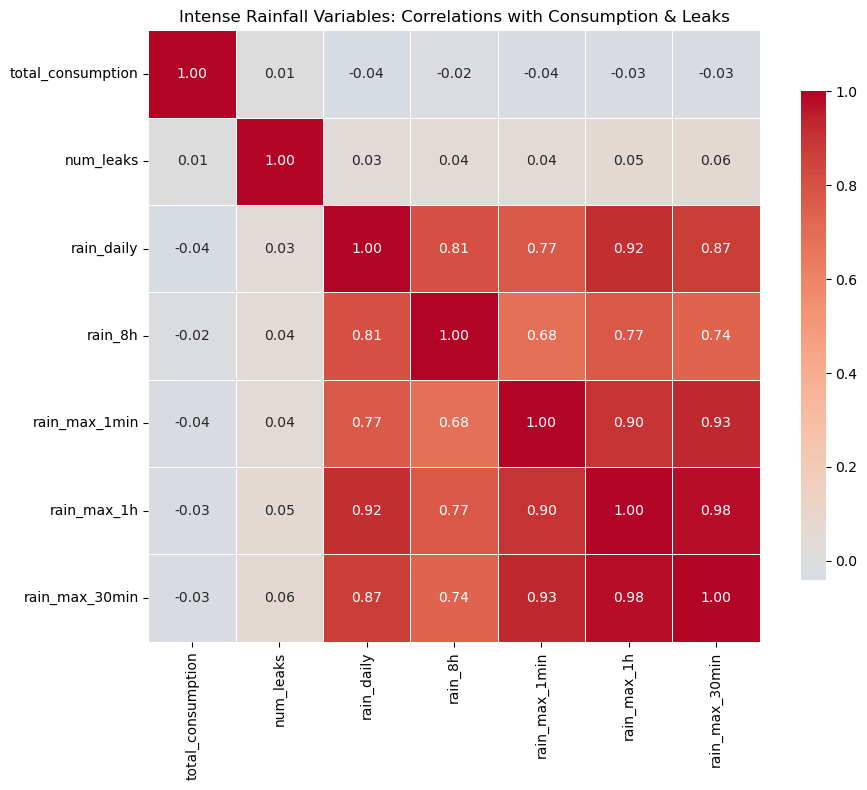

In [46]:
# Visualize rainfall correlation matrix
plt.figure(figsize=(10, 8))
rainfall_corr_viz = rainfall_corr.loc[['total_consumption', 'num_leaks'] + rainfall_vars_available,
                                        ['total_consumption', 'num_leaks'] + rainfall_vars_available]
sns.heatmap(
    rainfall_corr_viz,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Intense Rainfall Variables: Correlations with Consumption & Leaks")
plt.tight_layout()
plt.show()


#### 4.2.2 Extreme Rainfall Days Analysis


In [47]:
# Analyze extreme rainfall days using daily accumulation thresholds
if 'rain_daily' in rainfall_df.columns:
    # Define thresholds: moderate (>5mm), heavy (>20mm), extreme (>50mm)
    moderate_rain = rainfall_df['rain_daily'] > 5
    heavy_rain = rainfall_df['rain_daily'] > 20
    extreme_rain = rainfall_df['rain_daily'] > 50
    
    print("Rainfall thresholds:")
    print(f"  Moderate (>5mm):   {moderate_rain.sum():,} days")
    print(f"  Heavy (>20mm):     {heavy_rain.sum():,} days")
    print(f"  Extreme (>50mm):  {extreme_rain.sum():,} days")
    
    # Compare consumption and leaks on different rainfall intensity days
    print("\nConsumption comparison:")
    no_rain_mean = rainfall_df[rainfall_df['rain_daily'] == 0]['total_consumption'].mean()
    print(f"  No rain (0mm):     {no_rain_mean:,.0f} L/day")
    if moderate_rain.sum() > 0:
        print(f"  Moderate rain (>5mm): {rainfall_df[moderate_rain]['total_consumption'].mean():,.0f} L/day")
    if heavy_rain.sum() > 0:
        print(f"  Heavy rain (>20mm):   {rainfall_df[heavy_rain]['total_consumption'].mean():,.0f} L/day")
    if extreme_rain.sum() > 0:
        print(f"  Extreme rain (>50mm): {rainfall_df[extreme_rain]['total_consumption'].mean():,.0f} L/day")
    
    print("\nLeaks comparison:")
    no_rain_leaks = rainfall_df[rainfall_df['rain_daily'] == 0]['num_leaks'].mean()
    print(f"  No rain (0mm):     {no_rain_leaks:.2f} leaks/day")
    if moderate_rain.sum() > 0:
        print(f"  Moderate rain (>5mm): {rainfall_df[moderate_rain]['num_leaks'].mean():.2f} leaks/day")
    if heavy_rain.sum() > 0:
        print(f"  Heavy rain (>20mm):   {rainfall_df[heavy_rain]['num_leaks'].mean():.2f} leaks/day")
    if extreme_rain.sum() > 0:
        print(f"  Extreme rain (>50mm): {rainfall_df[extreme_rain]['num_leaks'].mean():.2f} leaks/day")
    
    # Analyze intensity metrics on days with heavy rainfall
    if 'rain_max_1h' in rainfall_df.columns and heavy_rain.sum() > 0:
        print("\nPEAK INTENSITY ANALYSIS (Heavy Rain Days)")
        print("="*80)
        heavy_rain_df = rainfall_df[heavy_rain]
        print(f"\nOn heavy rain days (>20mm):")
        if 'rain_max_1h' in heavy_rain_df.columns:
            print(f"  Average max 1h intensity: {heavy_rain_df['rain_max_1h'].mean():.2f} mm/h")
        if 'rain_max_30min' in heavy_rain_df.columns:
            print(f"  Average max 30min intensity: {heavy_rain_df['rain_max_30min'].mean():.2f} mm/30min")
        if 'rain_max_1min' in heavy_rain_df.columns:
            print(f"  Average max 1min intensity: {heavy_rain_df['rain_max_1min'].mean():.2f} mm/min")
else:
    print("⚠ rain_daily not available for extreme rainfall analysis")


Rainfall thresholds:
  Moderate (>5mm):   93 days
  Heavy (>20mm):     17 days
  Extreme (>50mm):  1 days

Consumption comparison:
  No rain (0mm):     2,582,656 L/day
  Moderate rain (>5mm): 2,502,155 L/day
  Heavy rain (>20mm):   2,471,467 L/day
  Extreme rain (>50mm): 2,524,199 L/day

Leaks comparison:
  No rain (0mm):     0.84 leaks/day
  Moderate rain (>5mm): 1.10 leaks/day
  Heavy rain (>20mm):   1.18 leaks/day
  Extreme rain (>50mm): 0.00 leaks/day

PEAK INTENSITY ANALYSIS (Heavy Rain Days)

On heavy rain days (>20mm):
  Average max 1h intensity: 12.41 mm/h
  Average max 30min intensity: 9.40 mm/30min
  Average max 1min intensity: 1.08 mm/min


In [48]:
# Store rainfall analysis results for later use
rainfall_results = {
    'consumption_correlations': consum_rainfall.to_dict(),
    'leaks_correlations': leaks_rainfall.to_dict(),
    'available_variables': rainfall_vars_available
}

print("✓ Rainfall analysis results stored in 'rainfall_results'")


✓ Rainfall analysis results stored in 'rainfall_results'


## 5. Recommendations for Vulnerability Score Variables

Based on the correlation analysis above, this section provides recommendations for:
1. **Which weather variables to include** in heatwave and rainfall vulnerability scores
2. **Suggested weights** for each variable based on correlation strength with consumption and leaks
3. **Rationale** for variable selection


In [49]:
# Helper function to normalize correlations to weights (0-1 scale, sum to 1)
def normalize_to_weights(corr_dict, min_corr_threshold=0.05):
    """
    Convert correlation strengths to normalized weights.
    Only include variables with |correlation| >= min_corr_threshold
    """
    # Filter by threshold
    filtered = {k: abs(v) for k, v in corr_dict.items() if abs(v) >= min_corr_threshold}
    
    if not filtered:
        return {}
    
    # Normalize to sum to 1
    total = sum(filtered.values())
    weights = {k: v / total for k, v in filtered.items()}
    
    return weights

# Heatwave vulnerability score recommendations
if 'heatwave_results' in globals():
    # Combine consumption and leaks correlations (weighted average)
    # Consumption is more important for heatwaves (water demand increases)
    consum_weight = 0.7  # 70% weight on consumption
    leaks_weight = 0.3   # 30% weight on leaks
    
    # Get correlations
    consum_corr = heatwave_results['consumption_correlations']
    leaks_corr = heatwave_results['leaks_correlations']
    
    # Combine correlations (weighted average)
    combined_heatwave = {}
    all_vars = set(list(consum_corr.keys()) + list(leaks_corr.keys()))
    
    for var in all_vars:
        consum_val = consum_corr.get(var, 0)
        leaks_val = leaks_corr.get(var, 0)
        # Use absolute values for combination
        combined = consum_weight * abs(consum_val) + leaks_weight * abs(leaks_val)
        combined_heatwave[var] = combined
    
    # Normalize to weights
    heatwave_weights = normalize_to_weights(combined_heatwave, min_corr_threshold=0.05)
    
    print("\nRecommended variables for HEATWAVE vulnerability score:")
    print("(Based on combined correlation with consumption 70% + leaks 30%)")
    print("\nVariable | Combined Corr | Suggested Weight | Rationale")
    print("-" * 80)
    
    for var, weight in sorted(heatwave_weights.items(), key=lambda x: x[1], reverse=True):
        combined_corr = combined_heatwave[var]
        consum_corr_val = consum_corr.get(var, 0)
        leaks_corr_val = leaks_corr.get(var, 0)
        
        # Determine rationale
        if 'temp_max' in var:
            rationale = "Peak temperature - strongest heatwave indicator"
        elif 'temp_avg' in var:
            rationale = "Average temperature - overall heat stress"
        elif 'solar' in var:
            rationale = "Solar radiation - direct heat input"
        elif 'evapotranspiration' in var:
            rationale = "Heat stress indicator - water loss from plants"
        elif 'humidity' in var:
            rationale = "Humidity affects perceived temperature (heat index)"
        elif 'temp_amplitude' in var:
            rationale = "Temperature range - thermal stress variation"
        else:
            rationale = "Additional temperature metric"
        
        print(f"{var:25s} | {combined_corr:6.3f}      | {weight:6.3f}        | {rationale}")
    
    print(f"\nTotal weight sum: {sum(heatwave_weights.values()):.3f}")
    
    # Store recommendations
    heatwave_recommendations = {
        'variables': list(heatwave_weights.keys()),
        'weights': heatwave_weights,
        'combined_correlations': combined_heatwave
    }
else:
    print("⚠ Heatwave analysis not run. Please run the heatwave analysis cell first.")
    heatwave_recommendations = None



Recommended variables for HEATWAVE vulnerability score:
(Based on combined correlation with consumption 70% + leaks 30%)

Variable | Combined Corr | Suggested Weight | Rationale
--------------------------------------------------------------------------------
temp_avg                  |  0.103      |  0.174        | Average temperature - overall heat stress
temp_min                  |  0.103      |  0.173        | Additional temperature metric
temp_avg_classic          |  0.102      |  0.172        | Average temperature - overall heat stress
temp_max                  |  0.098      |  0.166        | Peak temperature - strongest heatwave indicator
evapotranspiration        |  0.095      |  0.161        | Heat stress indicator - water loss from plants
solar_global              |  0.092      |  0.155        | Solar radiation - direct heat input

Total weight sum: 1.000


### 5.2 Rainfall Vulnerability Score Recommendations


In [52]:
# Rainfall vulnerability score recommendations
if 'rainfall_results' in globals():
    # For rainfall, leaks are more important (rainfall can cause infrastructure damage)
    consum_weight = 0.4  # 40% weight on consumption
    leaks_weight = 0.6   # 60% weight on leaks
    
    # Get correlations
    consum_corr = rainfall_results['consumption_correlations']
    leaks_corr = rainfall_results['leaks_correlations']
    
    # Combine correlations (weighted average)
    combined_rainfall = {}
    all_vars = set(list(consum_corr.keys()) + list(leaks_corr.keys()))
    
    for var in all_vars:
        consum_val = consum_corr.get(var, 0)
        leaks_val = leaks_corr.get(var, 0)
        # Use absolute values for combination
        combined = consum_weight * abs(consum_val) + leaks_weight * abs(leaks_val)
        combined_rainfall[var] = combined
    
    # Show combined correlations before filtering
    print("\nCombined correlations (before filtering):")
    for var, corr in sorted(combined_rainfall.items(), key=lambda x: x[1], reverse=True):
        print(f"  {var:25s}: {corr:.4f}")
    
    # Use a lower threshold for rainfall (0.03) since rainfall correlations are inherently weaker
    # Rainfall events are rarer and more sporadic, leading to weaker overall correlations
    rainfall_weights = normalize_to_weights(combined_rainfall, min_corr_threshold=0.03)
    
    if not rainfall_weights:
        print("\n⚠ Warning: No variables passed the 0.03 threshold.")
        print("   Using a lower threshold of 0.02 to capture important rainfall variables...")
        rainfall_weights = normalize_to_weights(combined_rainfall, min_corr_threshold=0.02)
    
    if rainfall_weights:
        print("\nRecommended variables for RAINFALL vulnerability score:")
        print("(Based on combined correlation with consumption 40% + leaks 60%)")
        print("\nVariable | Combined Corr | Suggested Weight | Rationale")
        print("-" * 80)
        
        for var, weight in sorted(rainfall_weights.items(), key=lambda x: x[1], reverse=True):
            combined_corr = combined_rainfall[var]
            
            # Determine rationale
            if 'rain_daily' in var:
                rationale = "Daily accumulation - total rainfall impact"
            elif 'rain_max_1h' in var:
                rationale = "Peak 1-hour intensity - flash flood risk"
            elif 'rain_max_30min' in var:
                rationale = "Peak 30-min intensity - intense short bursts"
            elif 'rain_max_1min' in var:
                rationale = "Peak 1-min intensity - extreme intensity events"
            elif 'rain_8h' in var:
                rationale = "8-hour window - sustained rainfall periods"
            else:
                rationale = "Rainfall metric"
            
            print(f"{var:25s} | {combined_corr:6.3f}      | {weight:6.3f}        | {rationale}")
        
        print(f"\nTotal weight sum: {sum(rainfall_weights.values()):.3f}")
    else:
        print("\n⚠ Warning: No rainfall variables met the minimum correlation threshold.")
        print("   This may indicate that rainfall events have weak correlations with consumption/leaks.")
        print("   Consider using all available rainfall variables or adjusting the threshold.")
    
    # Store recommendations
    if rainfall_weights:
        rainfall_recommendations = {
            'variables': list(rainfall_weights.keys()),
            'weights': rainfall_weights,
            'combined_correlations': combined_rainfall
        }
    else:
        # Fallback: use all variables with equal weights if none pass threshold
        print("\n⚠ Using fallback: All rainfall variables with equal weights")
        all_rainfall_vars = list(combined_rainfall.keys())
        equal_weight = 1.0 / len(all_rainfall_vars) if all_rainfall_vars else 0
        rainfall_weights_fallback = {var: equal_weight for var in all_rainfall_vars}
        
        rainfall_recommendations = {
            'variables': all_rainfall_vars,
            'weights': rainfall_weights_fallback,
            'combined_correlations': combined_rainfall
        }
        print(f"   Assigned equal weight of {equal_weight:.3f} to each of {len(all_rainfall_vars)} variables")
else:
    print("⚠ Rainfall analysis not run. Please run the rainfall analysis cell first.")
    rainfall_recommendations = None



Combined correlations (before filtering):
  rain_max_30min           : 0.0496
  rain_max_1h              : 0.0436
  rain_max_1min            : 0.0408
  rain_daily               : 0.0361
  rain_8h                  : 0.0312

Recommended variables for RAINFALL vulnerability score:
(Based on combined correlation with consumption 40% + leaks 60%)

Variable | Combined Corr | Suggested Weight | Rationale
--------------------------------------------------------------------------------
rain_max_30min            |  0.050      |  0.246        | Peak 30-min intensity - intense short bursts
rain_max_1h               |  0.044      |  0.216        | Peak 1-hour intensity - flash flood risk
rain_max_1min             |  0.041      |  0.203        | Peak 1-min intensity - extreme intensity events
rain_daily                |  0.036      |  0.179        | Daily accumulation - total rainfall impact
rain_8h                   |  0.031      |  0.155        | 8-hour window - sustained rainfall periods

Total 

### 5.3 Summary and Export

Summary of recommendations and export to configuration dictionary.


In [53]:
# Summary of recommendations
print("SUMMARY & NEXT STEPS")
print("="*120)

print("\n1. HEATWAVE VULNERABILITY SCORE:")
if 'heatwave_recommendations' in globals() and heatwave_recommendations:
    # Get top 3 variables sorted by weight (descending)
    top_3_heatwave = sorted(heatwave_recommendations['weights'].items(), key=lambda x: x[1], reverse=True)[:3]
    top_3_names = [var for var, _ in top_3_heatwave]
    
    print(f"   - Use {len(heatwave_recommendations['variables'])} variables")
    print(f"   - Top 3 variables (by weight): {', '.join(top_3_names)}")
    print(f"   - Variables available in df_corr: {heatwave_recommendations['variables']}")
else:
    print("   - Recommendations not available (run heatwave analysis)")

print("\n2. RAINFALL VULNERABILITY SCORE:")
if 'rainfall_recommendations' in globals() and rainfall_recommendations:
    # Get top 3 variables sorted by weight (descending)
    top_3_rainfall = sorted(rainfall_recommendations['weights'].items(), key=lambda x: x[1], reverse=True)[:3]
    top_3_names = [var for var, _ in top_3_rainfall]
    
    print(f"   - Use {len(rainfall_recommendations['variables'])} variables")
    print(f"   - Top 3 variables (by weight): {', '.join(top_3_names)}")
    print(f"   - Variables available in df_corr: {rainfall_recommendations['variables']}")
else:
    print("   - Recommendations not available (run rainfall analysis)")

print("\n3. IMPLEMENTATION IN vulnerabilityScore.ipynb:")
print("   - Use the recommended variables and weights from above")
print("   - Normalize weather variables before applying weights")
print("   - Consider section-level characteristics (consumption, leaks) as multipliers")
print("   - Combine daily weather vulnerability with section-level vulnerability")

# Export recommendations as a summary dictionary
vulnerability_score_config = {
    'heatwave': heatwave_recommendations if 'heatwave_recommendations' in globals() else None,
    'rainfall': rainfall_recommendations if 'rainfall_recommendations' in globals() else None
}

print("\n✓ Recommendations stored in 'vulnerability_score_config' dictionary")
print("  Access via: vulnerability_score_config['heatwave'] or ['rainfall']")

# Save configuration to JSON file for use in vulnerabilityScore.ipynb
import json

# Convert to JSON-serializable format (convert numpy types if any)
def make_json_serializable(obj):
    """Convert numpy types to native Python types for JSON serialization."""
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_json_serializable(item) for item in obj]
    elif isinstance(obj, (np.integer, np.floating)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

config_serializable = make_json_serializable(vulnerability_score_config)

config_file = "vulnerability_score_config.json"
with open(config_file, 'w') as f:
    json.dump(config_serializable, f, indent=2)

print(f"\n✓ Configuration saved to '{config_file}'")
print("  You can load this in vulnerabilityScore.ipynb with:")
print(f"  import json")
print(f"  with open('{config_file}', 'r') as f:")
print(f"      vulnerability_score_config = json.load(f)")


SUMMARY & NEXT STEPS

1. HEATWAVE VULNERABILITY SCORE:
   - Use 6 variables
   - Top 3 variables (by weight): temp_avg, temp_min, temp_avg_classic
   - Variables available in df_corr: ['solar_global', 'temp_max', 'temp_min', 'evapotranspiration', 'temp_avg_classic', 'temp_avg']

2. RAINFALL VULNERABILITY SCORE:
   - Use 5 variables
   - Top 3 variables (by weight): rain_max_30min, rain_max_1h, rain_max_1min
   - Variables available in df_corr: ['rain_max_1h', 'rain_8h', 'rain_max_1min', 'rain_max_30min', 'rain_daily']

3. IMPLEMENTATION IN vulnerabilityScore.ipynb:
   - Use the recommended variables and weights from above
   - Normalize weather variables before applying weights
   - Consider section-level characteristics (consumption, leaks) as multipliers
   - Combine daily weather vulnerability with section-level vulnerability

✓ Recommendations stored in 'vulnerability_score_config' dictionary
  Access via: vulnerability_score_config['heatwave'] or ['rainfall']

✓ Configuration save